# Bradley Adaptive Thresholding

In [85]:
%reload_ext autoreload
%autoreload 2
from IPython.core.pylabtools import figsize
from skimage import transform
figsize(9, 9)

import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
plt.set_cmap('gray')
from PIL import Image

def adaptive_thresh(img, s=None, t=None):

    # Convert image to numpy array
    #img = np.array(image).astype(np.float)

    # Default window size is round(cols/8)
    if s is None:
        s = np.round(img.shape[1]/8)

    # Default threshold is 15% of the total
    # area in the window
    if t is None:
        t = 25.0

    # Compute integral image
    intImage = np.cumsum(np.cumsum(img, axis=1), axis=0)

    # Define grid of points
    (rows,cols) = img.shape[:2]
    (X,Y) = np.meshgrid(np.arange(cols), np.arange(rows))

    # Make into 1D grid of coordinates for easier access
    X = X.ravel()
    Y = Y.ravel()

    # Ensure s is even so that we are able to index into the image
    # properly
    s = s + np.mod(s,2)

    # Access the four corners of each neighbourhood
    x1 = X - s/2
    x2 = X + s/2
    y1 = Y - s/2
    y2 = Y + s/2

    # Ensure no coordinates are out of bounds
    x1[x1 < 0] = 0
    x2[x2 >= cols] = cols-1
    y1[y1 < 0] = 0
    y2[y2 >= rows] = rows-1


    # Count how many pixels are in each neighbourhood
    count = (x2 - x1) * (y2 - y1)

    # Compute the row and column coordinates to access
    # each corner of the neighbourhood for the integral image
    f1_x = x2.astype(int)
    f1_y = y2.astype(int)
    f2_x = x2.astype(int)
    f2_y = (y1 - 1).astype(int)
    f2_y[f2_y < 0] = 0
    f3_x = (x1-1).astype(int)
    f3_x[f3_x < 0] = 0
    f3_y = y2.astype(int)
    f4_x = f3_x.astype(int)
    f4_y = f2_y.astype(int)

    
    # Compute areas of each window
    sums = intImage[f1_y, f1_x] - intImage[f2_y, f2_x] - intImage[f3_y, f3_x] + intImage[f4_y, f4_x]

    # Compute thresholded image and reshape into a 2D grid
    out = np.ones(rows*cols, dtype=np.bool)
    out[img.ravel()*count <= sums*(100.0 - t)/100.0] = False

    # Also convert back to uint8
    out = 255*np.reshape(out, (rows, cols)).astype(np.uint8)
    return out

## Testing sample image

/Users/srivathsa/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


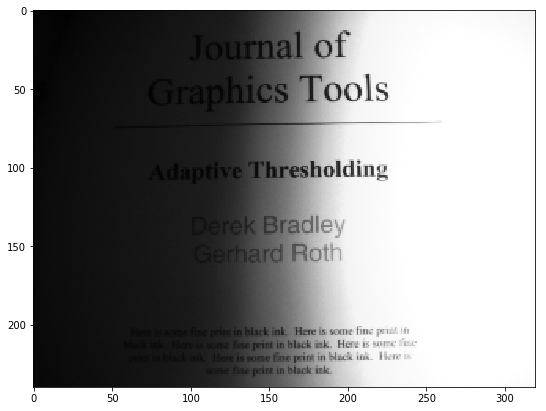

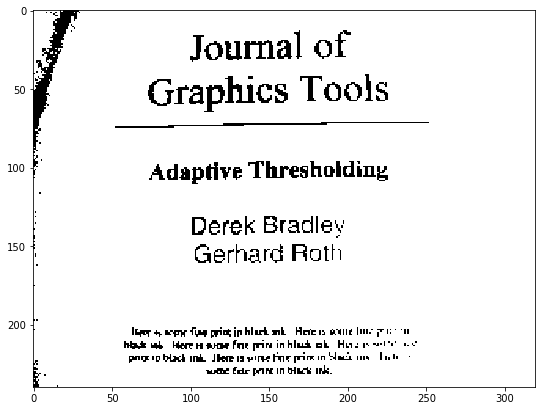

In [86]:
import numpy as np

img = misc.imread('bradley_test.png')
th_img = adaptive_thresh(img)

plt.imshow(img)
plt.show()

plt.imshow(th_img)
plt.show()


## Testing cell_detection_0 slice

In [87]:
from tifffile import imsave, imread
from datetime import datetime
img = imread('../data/s3617/tifs/cell_detection_0.tiff')

out_img = np.zeros_like(img, dtype=np.uint16)
print('start', datetime.now())

for z in range(img.shape[0]):
    img_slice = img[z, : ,:]
    img_slice = img_slice.max() - img_slice

    th_img_slice = adaptive_thresh(img_slice)
    th_img_slice = th_img_slice.max() - th_img_slice
    
    out_img[z, :, :] = th_img_slice

print('end', datetime.now())
imsave('bradley_threshold.tiff', out_img)


start 2018-04-03 22:08:37.670148
end 2018-04-03 22:08:40.087047
